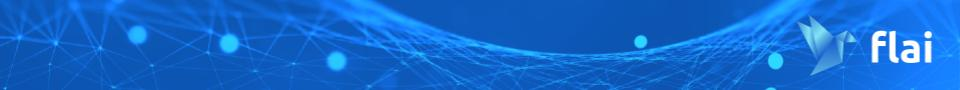

 # **Aula 3 - Spark MLlib para ajudar modelo de Regressão com PySpark**

É corriqueiro na vida dos seres humanos, inclusive no Brasil, que o lugar onde reside não seja próprio. Muitos Brasileiros residem em casas/apartamentos 🏢 de outros donos, e, apesar de em algumas situações os moradores não precisar pagar nenhum valor por essa moradia, na grande maioria é preciso pagar um valor a qual chamamos de Aluguel.

Nesta aula, vamos utilizar uma amostra de mais de 10.000 imóveis de alugueis em cinco municípios brasileiros. O Conjunto de dados é composto por alguns atributos cidade,	área,	número de quartos, número de banheiros, vagas de garagem, qual andar se encontra o imóvel, se aceita animal, se está alugando por imobiliária e valores (em reais), tanto total, quanto os desagregados: aluguel, condomínio, iptu e seguro. 

Vamos ajustar modelos de machine learning 🤖 para a tarefa de Regressão 📈, sendo o alvo estimar o Valor Total do Aluguel 🤑 de acordo com as características dos imóveis 🏘️.

## **Preparando o ambiente para utilizar o PySpark**

### **Instalando o Java**

O Apache Spark depende de outros sistemas, portanto, antes do Spark é preciso instalar as dependências. Primeiro, deve-se instalar o java

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

### **Instalando o Apache Spark**

Em seguida, é preciso fazer o download do Spark, e, também, do hadoop, pois o Apache Spark roda sob o HDFS, em sua máquina (no caso aqui, na máquina virtual do Google Colab que você está usando.

In [72]:
# Fazendo download
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz

# Descompactando os arquivos
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

### **Configurando o ambiente**

Pronto! Agora precisamos dizer para o sistema onde encontrar o Java e o Spark, que instalamos a pouco neste ambiente.

In [73]:
# Importando a biblioteca os
import os

# Definindo a variável de ambiente do Java
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# Definindo a variável de ambiente do Spark
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

A seguir, vamos precisar da biblioteca findspark que vai nos permitir importar pacotes necessários para o funcionamento do pyspark



In [74]:
# instalando a findspark
!pip install -q findspark

In [75]:
#importando a findspark
import findspark

# iniciando o findspark
findspark.init()

## **Iniciando o PySpark**

Tudo certo até aqui? Ótimo, então agora vamos abrir um sessão Spark para poder trabalhar com este FrameWork.

In [6]:
# importando as bibliotecas necessárias
from pyspark import *
from pyspark.sql import *
from pyspark.sql import SparkSession


In [7]:
# iniciando o spark context
sc = SparkSession.builder.master('local[*]').getOrCreate()

# Verificando se a sessão foi criada
sc

## **Ingestão dos dados para o Apache Spark**

In [9]:
# Permitir o Google Colab utilizar arquivos do Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [10]:
 # carregando um conjunto de dados
aluguel = (sc.read
      .format('csv')
      .option('inferSchema',True)
      .option('delimiter',';')
      .option('header',True)
      .option('encoding','UTF-8')
      .load('/content/drive/Shareddrives/Comunidade/Datasets/aluguel.csv')
)

# Espiando o dataset
aluguel.show()

+--------------+----+-------+---------+-------------+-----+-------------+----------+----------------+-------------+----------+------------+-----------+
|        cidade|area|quartos|banheiros|vagas_garagem|andar|aceita_animal|mobiliaria|valor_condominio|valor_aluguel|valor_iptu|valor_seguro|valor_total|
+--------------+----+-------+---------+-------------+-----+-------------+----------+----------------+-------------+----------+------------+-----------+
|     São Paulo|  70|      2|        1|            1|    7|            1|         1|            2065|         3300|       211|          42|       5618|
|     São Paulo| 320|      4|        4|            0|   20|            1|         0|            1200|         4960|      1750|          63|       7973|
|  Porto Alegre|  80|      1|        1|            1|    6|            1|         0|            1000|         2800|         0|          41|       3841|
|  Porto Alegre|  51|      2|        1|            0|    2|            1|         0|    

In [11]:
# Verificando o Schema
aluguel.printSchema()

root
 |-- cidade: string (nullable = true)
 |-- area: integer (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- vagas_garagem: integer (nullable = true)
 |-- andar: integer (nullable = true)
 |-- aceita_animal: integer (nullable = true)
 |-- mobiliaria: integer (nullable = true)
 |-- valor_condominio: integer (nullable = true)
 |-- valor_aluguel: integer (nullable = true)
 |-- valor_iptu: integer (nullable = true)
 |-- valor_seguro: integer (nullable = true)
 |-- valor_total: integer (nullable = true)



## **EDA - Análise Exploratória de Dados**


In [12]:
# importando os métodos com funções para transformações de variáveis
from pyspark.sql.functions import *

### **valor_total**

In [13]:
aluguel.describe('valor_total').show()

+-------+-----------------+
|summary|      valor_total|
+-------+-----------------+
|  count|            10685|
|   mean|5198.132615816566|
| stddev|4473.376270983826|
|    min|              499|
|    max|            32750|
+-------+-----------------+



In [14]:
aluguel.select('valor_total').summary(
     "min", '1%','5%', '10%',"25%", "50%","75%",'90%', '95%', 
     '99%', "max",'mean', 'stddev', 'count' ).show()

+-------+-----------------+
|summary|      valor_total|
+-------+-----------------+
|    min|              499|
|     1%|              811|
|     5%|             1128|
|    10%|             1384|
|    25%|             2060|
|    50%|             3577|
|    75%|             6758|
|    90%|            11610|
|    95%|            15150|
|    99%|            20230|
|    max|            32750|
|   mean|5198.132615816566|
| stddev|4473.376270983826|
|  count|            10685|
+-------+-----------------+



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe0f7c0a610>]],
      dtype=object)

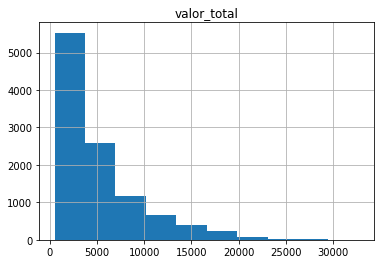

In [15]:
# Verificando a distribuição da remuneracao
aluguel.select('valor_total').toPandas().hist()

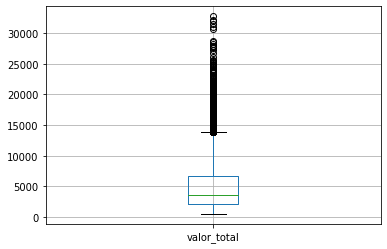

In [ ]:
aluguel.select('valor_total').toPandas().boxplot()

## **Transformando Variáveis**

### **valor_total**

In [16]:
# Transformando o preco em numerica
aluguel = aluguel.withColumn(
    colName = 'valor_total', 
    col = aluguel['valor_total'].cast('float')
    )

# Inspecionando o resultado
aluguel.select('valor_total').printSchema()
aluguel.show()

root
 |-- valor_total: float (nullable = true)

+--------------+----+-------+---------+-------------+-----+-------------+----------+----------------+-------------+----------+------------+-----------+
|        cidade|area|quartos|banheiros|vagas_garagem|andar|aceita_animal|mobiliaria|valor_condominio|valor_aluguel|valor_iptu|valor_seguro|valor_total|
+--------------+----+-------+---------+-------------+-----+-------------+----------+----------------+-------------+----------+------------+-----------+
|     São Paulo|  70|      2|        1|            1|    7|            1|         1|            2065|         3300|       211|          42|     5618.0|
|     São Paulo| 320|      4|        4|            0|   20|            1|         0|            1200|         4960|      1750|          63|     7973.0|
|  Porto Alegre|  80|      1|        1|            1|    6|            1|         0|            1000|         2800|         0|          41|     3841.0|
|  Porto Alegre|  51|      2|        1| 

## **Pré-Processamento para Machine Learning**

In [17]:
# Importando Bibliotecas e métodos necessários
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

In [18]:
aluguel_ml_temp = aluguel.select(
    'cidade', 
    'area',
    'quartos',
    'banheiros',
    'vagas_garagem',
    'andar',
    'aceita_animal', 
    'mobiliaria',
    'valor_total'
  )
aluguel_ml_temp.show()

+--------------+----+-------+---------+-------------+-----+-------------+----------+-----------+
|        cidade|area|quartos|banheiros|vagas_garagem|andar|aceita_animal|mobiliaria|valor_total|
+--------------+----+-------+---------+-------------+-----+-------------+----------+-----------+
|     São Paulo|  70|      2|        1|            1|    7|            1|         1|     5618.0|
|     São Paulo| 320|      4|        4|            0|   20|            1|         0|     7973.0|
|  Porto Alegre|  80|      1|        1|            1|    6|            1|         0|     3841.0|
|  Porto Alegre|  51|      2|        1|            0|    2|            1|         0|     1421.0|
|     São Paulo|  25|      1|        1|            0|    1|            0|         0|      836.0|
|     São Paulo| 376|      3|        3|            7|    0|            1|         0|     8955.0|
|Rio de Janeiro|  72|      2|        1|            0|    7|            1|         0|     2750.0|
|     São Paulo| 213|      4| 

In [24]:
aluguel_ml_temp.groupBy("cidade").count().show()

+--------------+-----+
|        cidade|count|
+--------------+-----+
|      Campinas|  853|
|Belo Horizonte| 1256|
|     São Paulo| 5883|
|Rio de Janeiro| 1500|
|  Porto Alegre| 1193|
+--------------+-----+



In [23]:
# Definindo uma categorização
def_categorias_cidade = StringIndexer(
    inputCols=['cidade'], 
    outputCols=['cidade_temp'])

# Aplicando a categorização
aluguel_ml_temp2 = def_categorias_cidade.fit(aluguel_ml_temp).transform(aluguel_ml_temp)
aluguel_ml_temp2.show()

+--------------+----+-------+---------+-------------+-----+-------------+----------+-----------+-----------+
|        cidade|area|quartos|banheiros|vagas_garagem|andar|aceita_animal|mobiliaria|valor_total|cidade_temp|
+--------------+----+-------+---------+-------------+-----+-------------+----------+-----------+-----------+
|     São Paulo|  70|      2|        1|            1|    7|            1|         1|     5618.0|        0.0|
|     São Paulo| 320|      4|        4|            0|   20|            1|         0|     7973.0|        0.0|
|  Porto Alegre|  80|      1|        1|            1|    6|            1|         0|     3841.0|        3.0|
|  Porto Alegre|  51|      2|        1|            0|    2|            1|         0|     1421.0|        3.0|
|     São Paulo|  25|      1|        1|            0|    1|            0|         0|      836.0|        0.0|
|     São Paulo| 376|      3|        3|            7|    0|            1|         0|     8955.0|        0.0|
|Rio de Janeiro|  7

In [26]:
# Definindo as dummy
def_cidade_para_dummy = OneHotEncoder(
    inputCols=['cidade_temp'], 
    outputCols=['cidade_dummy'], 
    dropLast= True
  )

# Criando as dummy
aluguel_ml_temp3 = def_cidade_para_dummy.fit(aluguel_ml_temp2).transform(aluguel_ml_temp2)
aluguel_ml_temp3.show(30)

+--------------+----+-------+---------+-------------+-----+-------------+----------+-----------+-----------+-------------+
|        cidade|area|quartos|banheiros|vagas_garagem|andar|aceita_animal|mobiliaria|valor_total|cidade_temp| cidade_dummy|
+--------------+----+-------+---------+-------------+-----+-------------+----------+-----------+-----------+-------------+
|     São Paulo|  70|      2|        1|            1|    7|            1|         1|     5618.0|        0.0|(4,[0],[1.0])|
|     São Paulo| 320|      4|        4|            0|   20|            1|         0|     7973.0|        0.0|(4,[0],[1.0])|
|  Porto Alegre|  80|      1|        1|            1|    6|            1|         0|     3841.0|        3.0|(4,[3],[1.0])|
|  Porto Alegre|  51|      2|        1|            0|    2|            1|         0|     1421.0|        3.0|(4,[3],[1.0])|
|     São Paulo|  25|      1|        1|            0|    1|            0|         0|      836.0|        0.0|(4,[0],[1.0])|
|     São Paulo|

In [ ]:

# Espiando o dataset resultante
print(aluguel_ml_temp3.printSchema())
aluguel_ml_temp3.show()

root
 |-- cidade: string (nullable = true)
 |-- area: integer (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- vagas_garagem: integer (nullable = true)
 |-- andar: integer (nullable = true)
 |-- aceita_animal: integer (nullable = true)
 |-- mobiliaria: integer (nullable = true)
 |-- valor_total: float (nullable = true)
 |-- cidade_temp: double (nullable = false)
 |-- cidade_dummy: vector (nullable = true)

None
+--------------+----+-------+---------+-------------+-----+-------------+----------+-----------+-----------+-------------+
|        cidade|area|quartos|banheiros|vagas_garagem|andar|aceita_animal|mobiliaria|valor_total|cidade_temp| cidade_dummy|
+--------------+----+-------+---------+-------------+-----+-------------+----------+-----------+-----------+-------------+
|     São Paulo|  70|      2|        1|            1|    7|            1|         1|     5618.0|        0.0|(4,[0],[1.0])|
|     São Paulo| 320|      4|        

In [ ]:
# Transformando para PandasDataFrame para visualizar elhor a estrutura
#aluguel_ml_temp3.toPandas().head()

,cidade,area,quartos,banheiros,vagas_garagem,andar,aceita_animal,mobiliaria,valor_total,cidade_temp,cidade_dummy
0,São Paulo,70,2,1,1,7,1,1,5618.0,0.0,"(1.0, 0.0, 0.0, 0.0)"
1,São Paulo,320,4,4,0,20,1,0,7973.0,0.0,"(1.0, 0.0, 0.0, 0.0)"
2,Porto Alegre,80,1,1,1,6,1,0,3841.0,3.0,"(0.0, 0.0, 0.0, 1.0)"
3,Porto Alegre,51,2,1,0,2,1,0,1421.0,3.0,"(0.0, 0.0, 0.0, 1.0)"
4,São Paulo,25,1,1,0,1,0,0,836.0,0.0,"(1.0, 0.0, 0.0, 0.0)"


In [27]:
# criando uma coluna com todas as preditoras
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# Definindo as preditoras
def_preditoras = VectorAssembler( 
    inputCols=[
    'area',
    'quartos',
    'banheiros',
    'vagas_garagem',
    'andar',
    'aceita_animal', 
    'mobiliaria',
    'cidade_dummy'],
    outputCol= 'preditoras'  
)

In [39]:
# criando uma coluna com todas as preditoras em novo dataset
aluguel_ml_temp4 = def_preditoras.transform(aluguel_ml_temp3)


+--------------+----+-------+---------+-------------+-----+-------------+----------+-----------+-----------+-------------+--------------------+
|        cidade|area|quartos|banheiros|vagas_garagem|andar|aceita_animal|mobiliaria|valor_total|cidade_temp| cidade_dummy|          preditoras|
+--------------+----+-------+---------+-------------+-----+-------------+----------+-----------+-----------+-------------+--------------------+
|     São Paulo|  70|      2|        1|            1|    7|            1|         1|     5618.0|        0.0|(4,[0],[1.0])|[70.0,2.0,1.0,1.0...|
|     São Paulo| 320|      4|        4|            0|   20|            1|         0|     7973.0|        0.0|(4,[0],[1.0])|(11,[0,1,2,4,5,7]...|
|  Porto Alegre|  80|      1|        1|            1|    6|            1|         0|     3841.0|        3.0|(4,[3],[1.0])|[80.0,1.0,1.0,1.0...|
|  Porto Alegre|  51|      2|        1|            0|    2|            1|         0|     1421.0|        3.0|(4,[3],[1.0])|(11,[0,1,2,4,5

In [44]:
aluguel_ml_temp4.select( 'preditoras').head(5)


[Row(preditoras=DenseVector([70.0, 2.0, 1.0, 1.0, 7.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0])),
 Row(preditoras=SparseVector(11, {0: 320.0, 1: 4.0, 2: 4.0, 4: 20.0, 5: 1.0, 7: 1.0})),
 Row(preditoras=DenseVector([80.0, 1.0, 1.0, 1.0, 6.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0])),
 Row(preditoras=SparseVector(11, {0: 51.0, 1: 2.0, 2: 1.0, 4: 2.0, 5: 1.0, 10: 1.0})),
 Row(preditoras=SparseVector(11, {0: 25.0, 1: 1.0, 2: 1.0, 4: 1.0, 7: 1.0}))]

In [29]:
# Pegando somente os atributos que serao utilizados na modelagem
#df_salario_ml= df_salario_ml_temp5.select('log_remuneracao', 'preditoras')
aluguel_ml= aluguel_ml_temp4.select('valor_total', 'preditoras')

# Espiando dataset final
aluguel_ml.show()

+-----------+--------------------+
|valor_total|          preditoras|
+-----------+--------------------+
|     5618.0|[70.0,2.0,1.0,1.0...|
|     7973.0|(11,[0,1,2,4,5,7]...|
|     3841.0|[80.0,1.0,1.0,1.0...|
|     1421.0|(11,[0,1,2,4,5,10...|
|      836.0|(11,[0,1,2,4,7],[...|
|     8955.0|(11,[0,1,2,3,5,7]...|
|     2750.0|(11,[0,1,2,4,5,8]...|
|     7253.0|[213.0,4.0,4.0,4....|
|    16440.0|[152.0,2.0,2.0,1....|
|     2955.0|[35.0,1.0,1.0,0.0...|
|     2747.0|[26.0,1.0,1.0,0.0...|
|     1181.0|(11,[0,1,2,3,4,5]...|
|     2556.0|(11,[0,1,2,4,5,7]...|
|     5268.0|[55.0,1.0,1.0,1.0...|
|     5343.0|[100.0,2.0,2.0,2....|
|     9129.0|(11,[0,1,2,3,5,6]...|
|     3861.0|[110.0,2.0,2.0,1....|
|     5351.0|[88.0,2.0,3.0,1.0...|
|     2036.0|(11,[0,1,2,4,5,8]...|
|    21680.0|(11,[0,1,2,3,5,7]...|
+-----------+--------------------+
only showing top 20 rows



## **Dividindo o dataset entre treino e teste**

In [30]:
# Separando os dados entre treino e teste
aluguel_treino, aluguel_teste = aluguel_ml.randomSplit([.8,.2], seed=16032018)

## **Regressão Linear**



In [31]:
from pyspark.ml.regression import LinearRegression
#from pyspark.mllib.evaluation import RegressionMetrics


In [32]:
# Definindo o modelo de regressão
rl = LinearRegression(
    featuresCol='preditoras', 
    labelCol= 'valor_total', 
    predictionCol='valor_total_pred'
)

In [33]:
# Treinando o modeo
modelo_rl = rl.fit(aluguel_treino)

In [34]:
# Pegando o intercepto do modelo
modelo_rl.intercept

-2175.5078109881247

In [35]:
# Pegando os coeficientes da regressão
print(len(modelo_rl.coefficients))
modelo_rl.coefficients

11


DenseVector([1.2616, 408.3143, 1410.6211, 543.6388, 118.409, -113.1395, 1368.488, 1766.9434, 1890.0664, 261.9392, 424.8172])

In [36]:
# Verificando as métricas da qualidade do ajuste do modelo através
# do atributo LinearRegressionModel.summary

print("RMSE: {0}".format(modelo_rl.summary.rootMeanSquaredError))
print("MAE: {0}".format(modelo_rl.summary.meanAbsoluteError))
print("R2: {0}".format(modelo_rl.summary.r2))

RMSE: 2901.2501526069364
MAE: 1915.5463556158998
R2: 0.5828655673597521


In [40]:
# Ajustando o modelo aos dados de teste
modelo_rl_pred = modelo_rl.transform(aluguel_teste)

In [41]:
# Selecionando a coluna das remuneracoes preditas e observadas
predita_observada = modelo_rl_pred.select('valor_total_pred','valor_total')
predita_observada.show()

+-------------------+-----------+
|   valor_total_pred|valor_total|
+-------------------+-----------+
|    66.892733571583|      557.0|
|  642.1615450785325|      559.0|
| 1441.9104537420121|      610.0|
| 1347.6946595389195|      640.0|
| 173.72435752347383|      659.0|
| 1460.8341983652094|      660.0|
| 1565.0335393439104|      671.0|
| 1448.2183686164112|      697.0|
| 1360.3104892877177|      701.0|
| 1420.0185657373577|      710.0|
| 1439.2781707688223|      710.0|
|-188.84904588058862|      719.0|
| 1360.3104892877177|      756.0|
| 1570.3030179321077|      760.0|
| 1558.7256244695113|      760.0|
| 1360.3104892877177|      778.0|
|  130.2854746962439|      784.0|
| 1473.4500281140076|      787.0|
| 1344.2707377085985|      797.0|
|  117.6696449474457|      798.0|
+-------------------+-----------+
only showing top 20 rows



In [76]:
# Verificando as métricas da qualidade do ajuste do modelo através
# do RegressionEvaluator do pacote pyspark.ml

from pyspark.ml.evaluation import RegressionEvaluator

# RMSE
evaluator = RegressionEvaluator(
    predictionCol="valor_total_pred", 
    labelCol='valor_total', 
    metricName='rmse'
)
print("RMSE: {0}".format(evaluator.evaluate(predita_observada)))

# MAE
evaluator = RegressionEvaluator(
    predictionCol="valor_total_pred", 
    labelCol='valor_total', 
    metricName='mae'
)
print("MAE: {0}".format(evaluator.evaluate(predita_observada)))

# R^2
evaluator = RegressionEvaluator(
    predictionCol="valor_total_pred", 
    labelCol='valor_total', 
    metricName='r2'
)
print("R2: {0}".format(evaluator.evaluate(predita_observada)))


RMSE: 2624.468728474207
MAE: 1778.3682335353894
R2: 0.6435715409876974


In [46]:
# Verificando as métricas da qualidade do ajuste do modelo através
# do RegressionEvaluator do pacote pyspark.ml

from pyspark.mllib.evaluation import RegressionMetrics

# mllib is old so the methods are available in rdd
metricas_modelo_rl = RegressionMetrics(predita_observada.rdd)

print("RMSE: {0}".format(metricas_modelo_rl.rootMeanSquaredError))
print("MAE: {0}".format(metricas_modelo_rl.meanAbsoluteError))
print("R2: {0}".format(metricas_modelo_rl.r2))

RMSE: 3175.4503570784027
MAE: 1955.9534456727106
R2: 0.4782046271527236


## **Árvore de Decisão**

In [47]:
from pyspark.ml.regression import DecisionTreeRegressor

In [48]:
# definindo a árvore
dt= DecisionTreeRegressor(
    featuresCol='preditoras', 
    labelCol='valor_total', 
    predictionCol='valor_total_pred', 
    maxDepth=5)

In [49]:
# Treinando a árvore
modelo_dt = dt.fit(aluguel_treino)

In [50]:
# Ajustando a árvore aos dados de teste
modelo_dt_pred = modelo_dt.transform(aluguel_teste)

In [51]:
# Selecionando a coluna das valor_total preditas e observadas
predita_observada = modelo_dt_pred.select('valor_total_pred','valor_total')
predita_observada.show()

+------------------+-----------+
|  valor_total_pred|valor_total|
+------------------+-----------+
|1691.7824074074074|      557.0|
|1691.7824074074074|      559.0|
|1691.7824074074074|      610.0|
|1691.7824074074074|      640.0|
|1691.7824074074074|      659.0|
|1691.7824074074074|      660.0|
|1691.7824074074074|      671.0|
|1691.7824074074074|      697.0|
|1691.7824074074074|      701.0|
|2584.7724719101125|      710.0|
|1691.7824074074074|      710.0|
|1691.7824074074074|      719.0|
|1691.7824074074074|      756.0|
|1691.7824074074074|      760.0|
|1691.7824074074074|      760.0|
|1691.7824074074074|      778.0|
|1691.7824074074074|      784.0|
|1691.7824074074074|      787.0|
| 2433.451497005988|      797.0|
|1691.7824074074074|      798.0|
+------------------+-----------+
only showing top 20 rows



In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import RegressionMetrics

# Calculando as métricas
metricas_modelo_dt = RegressionMetrics(predita_observada.rdd)

# Calculando as métricas
print("RMSE: {0}".format(metricas_modelo_dt.rootMeanSquaredError))
print("MAE: {0}".format(metricas_modelo_dt.meanAbsoluteError))
print("R2: {0}".format(metricas_modelo_dt.r2))

RMSE: 2742.7522209589088
MAE: 1840.5024583381212
R2: 0.6107194375575244


## **Random Forest**

In [53]:
from pyspark.ml.regression import RandomForestRegressor

In [54]:
# definindo a floresta
rf= RandomForestRegressor(
    featuresCol='preditoras', 
    labelCol='valor_total', 
    predictionCol='valor_total_pred', 
    maxDepth=5, 
    numTrees=10)

In [55]:
# Treinando a floresta
modelo_rf = rf.fit(aluguel_treino)

In [56]:
# Ajustando a floresta aos dados de teste
modelo_rf_pred = modelo_rf.transform(aluguel_teste)

In [57]:
# Selecionando a coluna das valor_total preditas e observadas
predita_observada = modelo_rf_pred.select('valor_total_pred','valor_total')
predita_observada.show(50)

+------------------+-----------+
|  valor_total_pred|valor_total|
+------------------+-----------+
|1701.9972913056304|      557.0|
|1948.1015114129823|      559.0|
|1859.1981389826633|      610.0|
|1859.1981389826633|      640.0|
|1701.9972913056304|      659.0|
|1859.1981389826633|      660.0|
|1863.7183586073256|      671.0|
|1859.1981389826633|      697.0|
|1859.1981389826633|      701.0|
|2481.0553302150993|      710.0|
|1863.7183586073256|      710.0|
|1701.9972913056304|      719.0|
|1859.1981389826633|      756.0|
|1863.7183586073256|      760.0|
|1863.7183586073256|      760.0|
|1859.1981389826633|      778.0|
|1701.9972913056304|      784.0|
|1859.1981389826633|      787.0|
|2072.9249930082187|      797.0|
|1701.9972913056304|      798.0|
|1859.1981389826633|      809.0|
|1859.1981389826633|      809.0|
|1859.1981389826633|      813.0|
|3016.6659324059183|      815.0|
|1701.9972913056304|      817.0|
|2378.8459446544234|      831.0|
|2446.1148184089225|      835.0|
|2169.5077

In [58]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import RegressionMetrics

# Calculando as métricas
metricas_modelo_rf = RegressionMetrics(predita_observada.rdd)

# Verificando as métricas
print("RMSE: {0}".format(metricas_modelo_rf.rootMeanSquaredError))
print("MAE: {0}".format(metricas_modelo_rf.meanAbsoluteError))
print("R2: {0}".format(metricas_modelo_rf.r2))

RMSE: 2624.468728474207
MAE: 1778.3682335353894
R2: 0.6435715409876974


## **Tunando o Random Forest**

In [59]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.tuning import CrossValidator


In [60]:
# definindo a floresta
floresta = RandomForestRegressor(
    featuresCol='preditoras', 
    labelCol='valor_total', 
    predictionCol='valor_total_pred'
    )

In [61]:
pipeline = Pipeline(stages=[floresta])

In [62]:
paramGrid = ParamGridBuilder() \
    .addGrid(floresta.maxDepth, [3, 5, 7]) \
    .addGrid(floresta.numTrees, [10, 50, 100]) \
    .build()

In [63]:
paramGrid

[{Param(parent='RandomForestRegressor_0cb0d94967ac', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3,
  Param(parent='RandomForestRegressor_0cb0d94967ac', name='numTrees', doc='Number of trees to train (>= 1).'): 10},
 {Param(parent='RandomForestRegressor_0cb0d94967ac', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3,
  Param(parent='RandomForestRegressor_0cb0d94967ac', name='numTrees', doc='Number of trees to train (>= 1).'): 50},
 {Param(parent='RandomForestRegressor_0cb0d94967ac', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3,
  Param(parent='RandomForestRegressor_0cb0d94967ac', name='numTrees', doc='Number of trees to train (>= 1).'): 100},
 {Param(parent='RandomForestRegressor_0cb0d94967ac', name='maxDepth',

In [64]:
avaliador = RegressionEvaluator(
    predictionCol="valor_total_pred", 
    labelCol='valor_total', 
    metricName='mae'
)

### **Utilizando TrainValidationSplit**

In [65]:
# Definindo a tunagem através um hold-out com 1-fold
tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=avaliador,
                           trainRatio=0.8)

In [66]:
# Rodando hold-out e escolhendo o melhor conjunto de parâmetros
modelo_rf_tvs = tvs.fit(aluguel_treino)

In [67]:
#Verificando os modelos e a métrica MAE
list(zip(modelo_rf_tvs.validationMetrics, modelo_rf_tvs.getEstimatorParamMaps()))

[(1972.2830482225656,
  {Param(parent='RandomForestRegressor_0cb0d94967ac', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3,
   Param(parent='RandomForestRegressor_0cb0d94967ac', name='numTrees', doc='Number of trees to train (>= 1).'): 10}),
 (1965.539674078278,
  {Param(parent='RandomForestRegressor_0cb0d94967ac', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3,
   Param(parent='RandomForestRegressor_0cb0d94967ac', name='numTrees', doc='Number of trees to train (>= 1).'): 50}),
 (1977.1583284190544,
  {Param(parent='RandomForestRegressor_0cb0d94967ac', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3,
   Param(parent='RandomForestRegressor_0cb0d94967ac', name='numTrees', doc='Number of trees to train (>= 1).'): 10

In [68]:
# Verificand os MAE dos modelos
modelo_rf_tvs.validationMetrics

[1972.2830482225656,
 1965.539674078278,
 1977.1583284190544,
 1803.1944070266343,
 1777.889662475681,
 1776.5114565523602,
 1705.5365657940965,
 1671.9883631348616,
 1669.0625997032225]

In [71]:
# Aplicando o melhor modelo ao conjunto de teste
# Pegando os valores observados e preditos da variável target
predita_observada_tvs = modelo_rf_tvs.\
                        transform(aluguel_teste).\
                        select('valor_total_pred','valor_total')

+------------------+-----------+
|  valor_total_pred|valor_total|
+------------------+-----------+
|1569.9056543796798|      557.0|
|1587.7089796877463|      559.0|
| 1517.761261763416|      610.0|
|1568.8760494520247|      640.0|
|  1542.95249694229|      659.0|
| 1517.761261763416|      660.0|
|1624.3791357531964|      671.0|
| 1517.761261763416|      697.0|
| 1581.033440146277|      701.0|
| 2115.982500454619|      710.0|
|1631.6532231748383|      710.0|
| 1451.908020320789|      719.0|
| 1581.033440146277|      756.0|
|1731.4348256053743|      760.0|
|1624.3791357531964|      760.0|
| 1581.033440146277|      778.0|
|1531.7389154875552|      784.0|
|1529.9186524576683|      787.0|
|  2064.74278312133|      797.0|
| 1523.904547984579|      798.0|
+------------------+-----------+
only showing top 20 rows



In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import RegressionMetrics

# Calculando as métricas
metricas_modelo_rf_tvs = RegressionMetrics(predita_observada_tvs.rdd)

# Verificando as métricas
print("RMSE: {0}".format(metricas_modelo_rf_tvs.rootMeanSquaredError))
print("MAE: {0}".format(metricas_modelo_rf_tvs.meanAbsoluteError))
print("R2: {0}".format(metricas_modelo_rf_tvs.r2))

RMSE: 2499.275093088556
MAE: 1655.3423219144674
R2: 0.6767655132384259


### **Utilizando o CrossValidator**

In [ ]:
# Definindo a validação cruzada com 3-fold
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=avaliador,
                          numFolds=3)

In [ ]:
# Rodando a validação cruzada e escolhendo o melhor conjunto de parâmetros
modelo_rf_cv = crossval.fit(aluguel_treino)

In [ ]:
#Verificando os modelos e a métrica MAE
list(zip(modelo_rf_cv.avgMetrics, modelo_rf_cv.getEstimatorParamMaps()))

[(1946.3942655876579,
  {Param(parent='RandomForestRegressor_9a673751cec2', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3,
   Param(parent='RandomForestRegressor_9a673751cec2', name='numTrees', doc='Number of trees to train (>= 1).'): 10}),
 (1967.6283315830494,
  {Param(parent='RandomForestRegressor_9a673751cec2', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3,
   Param(parent='RandomForestRegressor_9a673751cec2', name='numTrees', doc='Number of trees to train (>= 1).'): 50}),
 (1944.9192074612338,
  {Param(parent='RandomForestRegressor_9a673751cec2', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 3,
   Param(parent='RandomForestRegressor_9a673751cec2', name='numTrees', doc='Number of trees to train (>= 1).'): 1

In [ ]:
# Verificando os MAE dos modelos
modelo_rf_cv.avgMetrics

[1946.3942655876579,
 1967.6283315830494,
 1944.9192074612338,
 1770.850583924924,
 1760.2157177616727,
 1750.6067997025457,
 1661.9089116087384,
 1653.7753043696553,
 1644.0188948940188]

In [ ]:
# Aplicando o melhor modelo ao conjunto de teste
# Pegando os valores observados e preditos da variável target
predita_observada_cv = modelo_rf_cv.\
                        transform(aluguel_teste).\
                        select('valor_total_pred','valor_total')

In [ ]:
# Verificando as métricas da qualidade do ajuste do modelo

from pyspark.mllib.evaluation import RegressionMetrics

# Calculando as métricas
metricas_modelo_rf_cv = RegressionMetrics(predita_observada_cv.rdd)

# Verificando as métricas
print("RMSE: {0}".format(metricas_modelo_rf_cv.rootMeanSquaredError))
print("MAE: {0}".format(metricas_modelo_rf_cv.meanAbsoluteError))
print("R2: {0}".format(metricas_modelo_rf_cv.r2))

RMSE: 2499.275093088556
MAE: 1655.3423219144674
R2: 0.6767655132384259


## **Comentários Finais**

Nesta aula utilizamos o Spark através da API PySpark para fazer ingestão, transformações e análise descritiva de dados. 

Também, fizemos pré-processamento para implementação de modelos de machine learning para tarefa de regressão, com objetivo de estimar o valor do aluguel baseado em algumas informações do imóvel. 

Inicialmente ajustamos 3 modelos: Regressão Linear, Árvore de Decisão e Random Forest. Para verificar o ajuste analisamos 3 métricas RMSE, MAE e R2. O Random Forest com 10 árvores e profundidade máximas das árvores igual a 5 foi a que apresentou os menores erros, tanto o RMSE - Raiz quadrada média dos erros quanto o MAE - Erro médio absoluto, bem como o maior R2.

Em seguida fizemos tunagem do random forest com um grid de 3 valores para a profundidade da árvore e 3 para o número de árvores. Utilizamos o MAE como métrica de validação e o melhor modelo que se apresentou foi o com 100 árvores e profundidade 7.

Vale ressaltar que estes foram ajustes puramente para fins de aprendizado e que outros modelos poderiam ser ajustados e, talvez, pudesse resultar em previsões mais precisas. Ainda, deve ser levado em consideração que o conjunto de dados disponível não possuia outras informações extremamente relevantes para determinar o valor do aluguel, como por exemplo, a localização dentro do município (região ou bairro) do imóvel, entre outras.

No site do Apache Spark tem uma documentação sobre SQL no Spark e que pode ser acessada no link https://spark.apache.org/docs/latest/sql-ref.html

A documentação oficial do PySpark, que contém o módulo SQL é extremamente útil e pode ser acessada em:
https://spark.apache.org/docs/latest/api/python/reference/

Para Machine Learning tem a documentação do MLlib em:
https://spark.apache.org/docs/latest/api/python/reference/pyspark.ml.html